# YoY Inflation Forecasting

### Imports

In [1]:
import os
import random
import numpy as np
import tensorflow as tf

# Set seeds
SEED = 35
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Set TF threading BEFORE any other TF usage
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import pmdarima as pm
from prophet import Prophet
from pandas_datareader import data as pdr
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from datetime import timedelta
from sklearn.linear_model import LinearRegression
from pmdarima import auto_arima
from sklearn.preprocessing import PolynomialFeatures

### Preparing Our Data

##### Read in the data

We use data from FRED throughout this project. We opt for features that have NO missing data.

In [3]:
# read the FRED CPI csv
df = pd.read_csv('cpi_monthly.csv')

# convert observation_date to datetime object
df['observation_date'] = pd.to_datetime(df['observation_date'])

# make the observation_date feature the index
df.set_index('observation_date', inplace=True)

# give the cpi column the correct name
df.rename(columns={'CPIAUCSL': 'cpi'}, inplace=True)

# create (YoY) inflation term
# NOTE: this is our target variable
df['inflation'] = df['cpi'].pct_change(12) * 100

# create date range
start = df.index.min()
end = df.index.max()

# create helper function (fetch, rename, and resample if needed)
def fetch_fred(series_id, name, resample=None):
    s = pdr.DataReader(series_id, 'fred', start, end)
    s.rename(columns={series_id: name}, inplace=True)
    if resample:
        s = s.resample(resample).mean()
    return s

# import additional FRED features we will use
external_features = {
    'UNRATE': 'unemployment_rate',
    'PPIACO': 'producer_price_index',
    'INDPRO': 'industrial_production',
    'CURRCIR': 'currency_circulation'
}

feature_dfs = []

for series_id, col_name in external_features.items():
    print(f"Fetching {col_name}...")
    if series_id in ['DCOILWTICO', 'CES0500000003']:  # daily or weekly → monthly
        feature_dfs.append(fetch_fred(series_id, col_name, resample='MS'))
    else:
        feature_dfs.append(fetch_fred(series_id, col_name))

# merge all into main df
for fdf in feature_dfs:
    df = df.merge(fdf, how='left', left_index=True, right_index=True)

# drop cpi and observation_date
df = df.drop(columns=['cpi'])

# missing data check for each feature in the df
print("Missing data:")
print(df.isna().sum())
print()

Fetching unemployment_rate...
Fetching producer_price_index...
Fetching industrial_production...
Fetching currency_circulation...
Missing data:
inflation                12
unemployment_rate        12
producer_price_index      0
industrial_production     0
currency_circulation      0
dtype: int64



##### Process the data

Here we create lags and seasonal terms, perform our train/test split, and scale our data.

In [4]:
# keep a copy
df_raw_features = df.copy()
df_raw_features = df_raw_features[df_raw_features.index >= "1950-01-01"]

# create lags
selected_lags = [1, 3, 6, 12, 24]
original_cols = df.columns.tolist()
for col in original_cols:
    for lag in selected_lags:
        df[f'{col}_lag_{lag}'] = df[col].shift(lag)

# drop non-lagged features
non_lagged_features = [col for col in original_cols if col != 'inflation']
print()
print("What We Drop:")
print(non_lagged_features)
print()
df = df.drop(columns=non_lagged_features)

# create monthly/quarterly terms
df['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
df['month_cos'] = np.cos(2 * np.pi * df.index.month / 12)

df['quarter_sin'] = np.sin(2 * np.pi * df.index.quarter / 4)
df['quarter_cos'] = np.cos(2 * np.pi * df.index.quarter / 4)

# cutoff data 
df = df[df.index >= "1950-01-01"]

# split the data
target_col = 'inflation'
feature_cols = df.columns.drop(target_col)

X = df[feature_cols].copy()
y = df[target_col].copy()

split_date = '2022-06-01' # make sure we test on most recent 24 months
X_train = X[X.index < split_date]
X_test = X[X.index >= split_date]
y_train = y[y.index < split_date]
y_test = y[y.index >= split_date]

# scale the data
no_scale_cols = ['month_sin', 'month_cos', 'quarter_sin', 'quarter_cos']
scale_cols = [col for col in X.columns if col not in no_scale_cols]

scaler = MinMaxScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test_scaled[scale_cols] = scaler.transform(X_test[scale_cols])

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))


What We Drop:
['unemployment_rate', 'producer_price_index', 'industrial_production', 'currency_circulation']



### Creating Our Models

Here, we try 5 models:
- LightGBM
- SimpleRNN
- LSTM
- DNN
- Ensemble Method (weighted combination of the above 4)

Note that our ensemble method only uses the top 3 performing models and weights each model's prediction based on its MAE.

##### First, create the models

In [5]:
# lightGBM (1)
lgb_model = lgb.LGBMRegressor()
lgb_model.fit(X_train_scaled, y_train_scaled.ravel())
lgb_pred = lgb_model.predict(X_test_scaled)
lgb_mae = mean_absolute_error(y_test_scaled, lgb_pred)

# DNN (2)
dnn_model = Sequential()
dnn_model.add(Input(shape=(X_train_scaled.shape[1],)))
dnn_model.add(Dense(64, activation='relu'))
dnn_model.add(Dense(64, activation='relu'))
dnn_model.add(Dense(1))
dnn_model.compile(optimizer=Adam(0.001), loss='mae')

dnn_model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=16, verbose=0,
              callbacks=[EarlyStopping(patience=5)])
dnn_pred = dnn_model.predict(X_test_scaled).flatten()
dnn_mae = mean_absolute_error(y_test_scaled, dnn_pred)

# prepare data for RNN & LSTM
def create_sequences(X, y, n_steps):
    Xs, ys = [], []
    for i in range(n_steps, len(X)):
        Xs.append(X[i - n_steps:i])
        ys.append(y[i - 1])  # align prediction with the last timestep in the window
    return np.array(Xs), np.array(ys)
n_steps = 12  # Use past 12 months as input
X_seq_train, y_seq_train = create_sequences(X_train_scaled, y_train_scaled, n_steps)
X_seq_test, y_seq_test = create_sequences(X_test_scaled, y_test_scaled, n_steps)

# RNN (3)
rnn_model = Sequential([
    SimpleRNN(64, return_sequences=True, input_shape=(n_steps, X_train_scaled.shape[1])),
    SimpleRNN(32),
    Dense(1)
])
rnn_model.compile(optimizer=Adam(0.001), loss='mae')

rnn_model.fit(X_seq_train, y_seq_train, epochs=100, batch_size=16, verbose=1,
              validation_split=0.1, callbacks=[EarlyStopping(patience=10)])
rnn_pred = rnn_model.predict(X_seq_test).flatten()
rnn_mae = mean_absolute_error(y_seq_test, rnn_pred)

# LSTM (4)
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(n_steps, X_train_scaled.shape[1])),
    LSTM(32),
    Dense(1)
])
lstm_model.compile(optimizer=Adam(0.001), loss='mae')

lstm_model.fit(X_seq_train, y_seq_train, epochs=100, batch_size=16, verbose=1,
               validation_split=0.1, callbacks=[EarlyStopping(patience=10)])
lstm_pred = lstm_model.predict(X_seq_test).flatten()
lstm_mae = mean_absolute_error(y_seq_test, lstm_pred)

# ensemble (5)

# DNN & LGB use last 25 rows of X_test_scaled
X_test_pred_only = X_test_scaled[n_steps:]
y_test_adjusted = y_test_scaled[n_steps:]

dnn_pred_seq = dnn_model.predict(X_test_pred_only).flatten()         # (25,)
lgb_pred_seq = lgb_model.predict(X_test_pred_only).flatten()         # (25,)
rnn_pred_seq = rnn_model.predict(X_seq_test).flatten()               # (25,)
lstm_pred_seq = lstm_model.predict(X_seq_test).flatten()             # (25,)

# Ensemble MAE-based softmax weights
maes = np.array([dnn_mae, rnn_mae, lstm_mae, lgb_mae])
model_preds = [dnn_pred_seq, rnn_pred_seq, lstm_pred_seq, lgb_pred_seq]

# Get top-3 indices
top3_idx = np.argsort(maes)[:3]  # lowest 3 MAEs
top3_maes = maes[top3_idx]
top3_preds = [model_preds[i] for i in top3_idx]

# Softmax-style weights (beta can be tuned)
beta = 7.5
weights = np.exp(-beta * top3_maes)
weights /= weights.sum()

# Weighted ensemble
ensemble_pred = sum(w * p for w, p in zip(weights, top3_preds))
ensemble_mae = mean_absolute_error(y_test_adjusted, ensemble_pred)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5487
[LightGBM] [Info] Number of data points in the train set: 869, number of used features: 29
[LightGBM] [Info] Start training from score 0.334760
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\shreyas.ramulu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Epoch 1/100


c:\Users\shreyas.ramulu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2967 - val_loss: 0.1153
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0777 - val_loss: 0.0831
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0719 - val_loss: 0.0659
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0566 - val_loss: 0.0630
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0546 - val_loss: 0.0627
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0598 - val_loss: 0.0531
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0440 - val_loss: 0.0524
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0401 - val_loss: 0.0487
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0350 - val_loss: 0.0468
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0340 - val_loss: 0.0505
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0340 - val_loss: 0.0686
Epoch 12/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0348 - val_lo

c:\Users\shreyas.ramulu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0858 - val_loss: 0.1655
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0634 - val_loss: 0.1199
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0534 - val_loss: 0.1347
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0478 - val_loss: 0.0633
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0451 - val_loss: 0.0852
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0431 - val_loss: 0.0650
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0408 - val_loss: 0.0922
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0394 - val_loss: 0.0565
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0395 - val_loss: 0.1014
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0395 - val_loss: 0.1184
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0383 - val_loss: 0.0928
Epoch 12/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0360 - val_l

In [6]:
print("DNN shape:", dnn_pred_seq.shape)
print("RNN shape:", rnn_pred_seq.shape)
print("LSTM shape:", lstm_pred_seq.shape)
print("LGB shape:", lgb_pred_seq.shape)
print("y_test shape:", y_test_adjusted.shape)

DNN shape: (25,)
RNN shape: (25,)
LSTM shape: (25,)
LGB shape: (25,)
y_test shape: (25, 1)


##### Second, evaluate and visualize how they performed

When we forecast later on, we will use whichever model does the best (whether its the ensemble, or an individual model)

0.5100596727452341


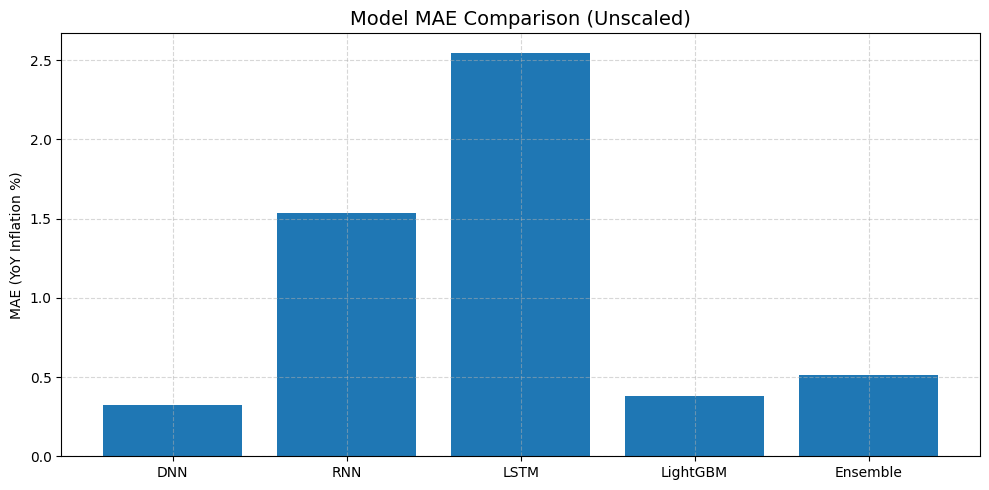

In [7]:
# mae bar chart

# Only take last 25 rows to align with model predictions
y_test_adjusted = y_test_scaled[n_steps:]  # shape (25,)
y_test_unscaled = y_scaler.inverse_transform(y_test_adjusted.reshape(-1, 1)).flatten()

# Unscale predictions
dnn_pred_unscaled = y_scaler.inverse_transform(dnn_pred_seq.reshape(-1, 1)).flatten()
rnn_pred_unscaled = y_scaler.inverse_transform(rnn_pred_seq.reshape(-1, 1)).flatten()
lstm_pred_unscaled = y_scaler.inverse_transform(lstm_pred_seq.reshape(-1, 1)).flatten()
lgb_pred_unscaled = y_scaler.inverse_transform(lgb_pred_seq.reshape(-1, 1)).flatten()
ensemble_pred_unscaled = y_scaler.inverse_transform(ensemble_pred.reshape(-1, 1)).flatten()

# Compute unscaled MAEs
dnn_mae_unscaled = mean_absolute_error(y_test_unscaled, dnn_pred_unscaled)
rnn_mae_unscaled = mean_absolute_error(y_test_unscaled, rnn_pred_unscaled)
lstm_mae_unscaled = mean_absolute_error(y_test_unscaled, lstm_pred_unscaled)
lgb_mae_unscaled = mean_absolute_error(y_test_unscaled, lgb_pred_unscaled)
ensemble_mae_unscaled = mean_absolute_error(y_test_unscaled, ensemble_pred_unscaled)
print(ensemble_mae_unscaled)

# Plot
models = ['DNN', 'RNN', 'LSTM', 'LightGBM', 'Ensemble']
mae_values_unscaled = [dnn_mae_unscaled, rnn_mae_unscaled, lstm_mae_unscaled, lgb_mae_unscaled, ensemble_mae_unscaled]

plt.figure(figsize=(10, 5))
plt.bar(models, mae_values_unscaled)
plt.ylabel('MAE (YoY Inflation %)')
plt.title('Model MAE Comparison (Unscaled)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


16.476307788734207


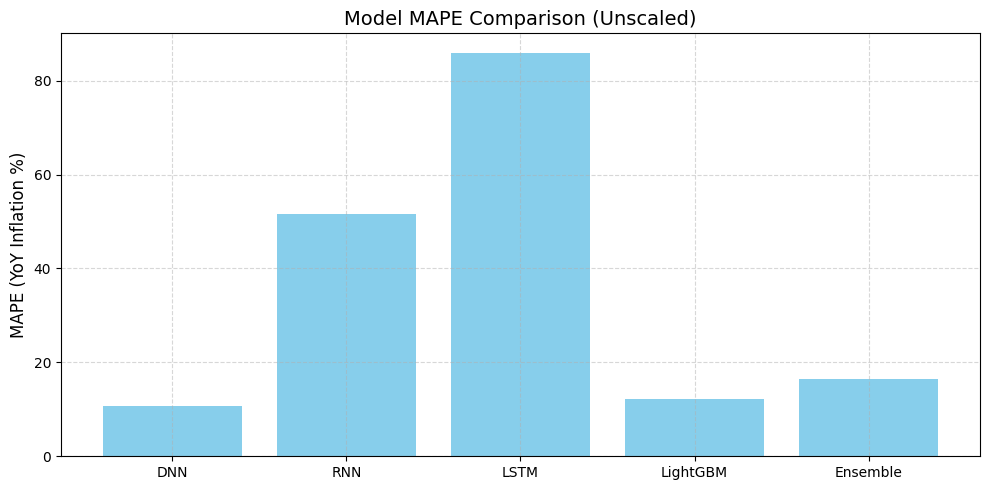

In [8]:
# mape bar chart

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

# Compute unscaled MAPEs (all lengths should be 25)
dnn_mape_unscaled = mean_absolute_percentage_error(y_test_unscaled, dnn_pred_unscaled)
rnn_mape_unscaled = mean_absolute_percentage_error(y_test_unscaled, rnn_pred_unscaled)
lstm_mape_unscaled = mean_absolute_percentage_error(y_test_unscaled, lstm_pred_unscaled)
lgb_mape_unscaled = mean_absolute_percentage_error(y_test_unscaled, lgb_pred_unscaled)
ensemble_mape_unscaled = mean_absolute_percentage_error(y_test_unscaled, ensemble_pred_unscaled)

# Plot bar chart
models = ['DNN', 'RNN', 'LSTM', 'LightGBM', 'Ensemble']
mape_values_unscaled = [dnn_mape_unscaled, rnn_mape_unscaled, lstm_mape_unscaled, lgb_mape_unscaled, ensemble_mape_unscaled]
print(ensemble_mape_unscaled)

plt.figure(figsize=(10, 5))
plt.bar(models, mape_values_unscaled, color='skyblue')
plt.ylabel('MAPE (YoY Inflation %)', fontsize=12)
plt.title('Model MAPE Comparison (Unscaled)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Here, we see that our ensemble actually performs slightly worse than the LightGBM model. However, we opt with the ensemble still, as it is better at generalizing.

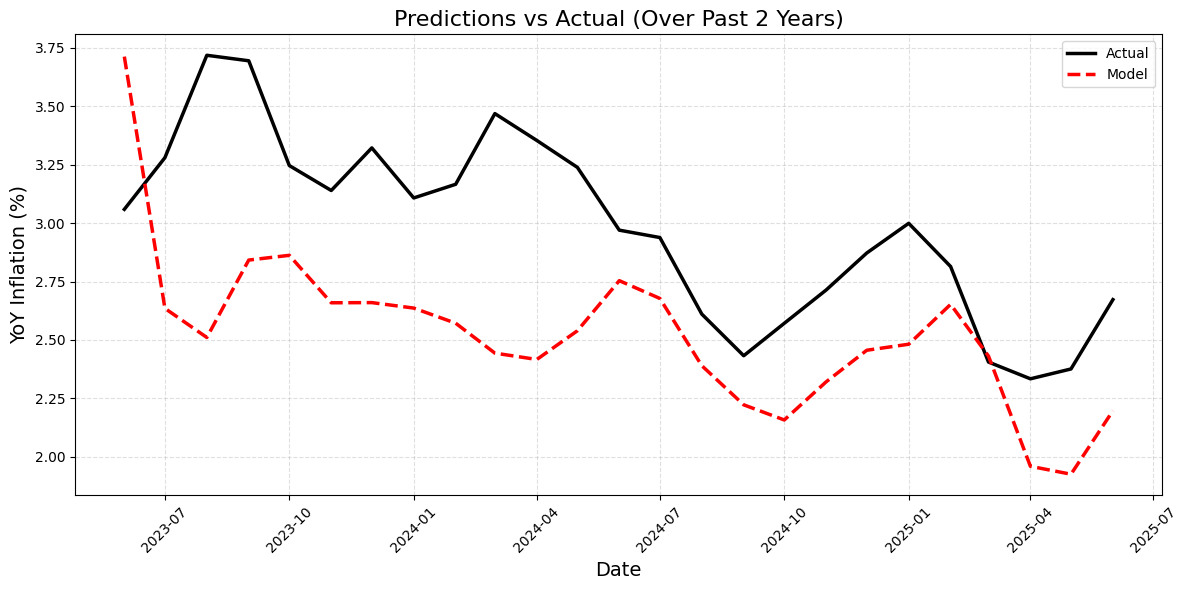

In [ ]:
# predictions visual

# Get x-axis values (dates for the 25 predicted months)
test_dates = y_test[n_steps:].index

# create plot
plt.figure(figsize=(12, 6))

# Main lines
plt.plot(test_dates, y_test_unscaled, label='Actual', linewidth=2.5, color='black')
plt.plot(test_dates, ensemble_pred_unscaled, label='Model', linestyle='--', linewidth=2.5, color='red')

# Formatting
plt.title('Predictions vs Actual (Over Past 2 Years)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('YoY Inflation (%)', fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


Here, we can see that the ensemble does a decent job at picking up large-scale trends. 

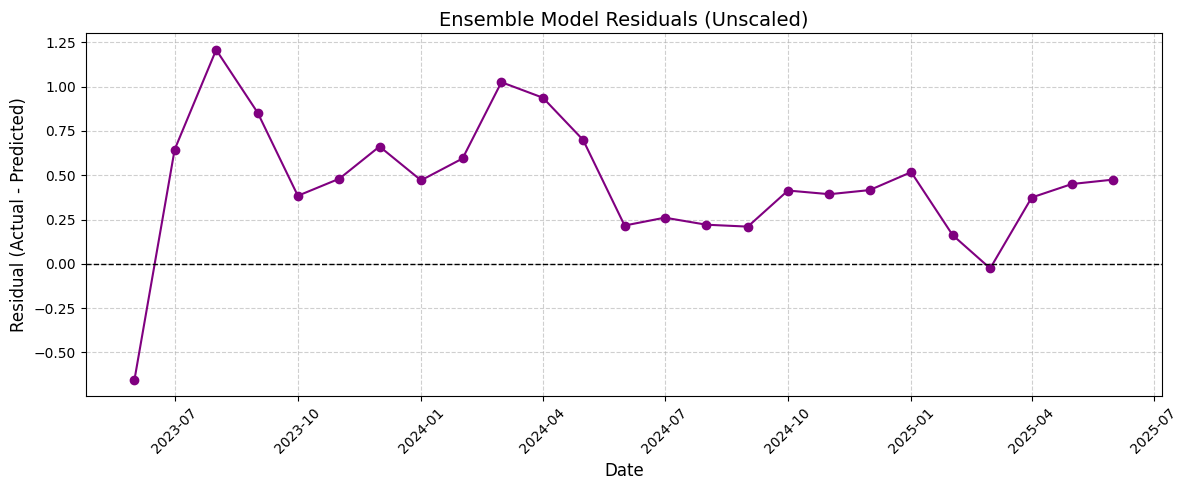

In [10]:
# residual plot for best performing model (ensemble)

# Calculate residuals for ensemble
ensemble_residuals = y_test_unscaled - ensemble_pred_unscaled  # both are length 25

# Get matching test dates
test_dates = y_test[n_steps:].index

# Residual plot
plt.figure(figsize=(12, 5))
plt.plot(test_dates, ensemble_residuals, marker='o', linestyle='-', color='purple')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Ensemble Model Residuals (Unscaled)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Residual (Actual - Predicted)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

There are no concerning patterns in our residual!

### Imputing Our Features

10:11:59 - cmdstanpy - INFO - Chain [1] start processing
10:11:59 - cmdstanpy - INFO - Chain [1] done processing
10:11:59 - cmdstanpy - INFO - Chain [1] start processing
10:12:00 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecasted features for future months:
            unemployment_rate  producer_price_index  industrial_production  \
2025-07-01           4.005745            248.512217             103.472030   
2025-08-01           3.938310            248.999378             103.584279   
2025-09-01           3.885281            249.487493             103.519481   
2025-10-01           3.863080            249.976566             103.644545   
2025-11-01           3.850764            250.466597             103.729181   

            currency_circulation  
2025-07-01           2691.993008  
2025-08-01           2707.030919  
2025-09-01           2722.152834  
2025-10-01           2737.359223  
2025-11-01           2752.650557  


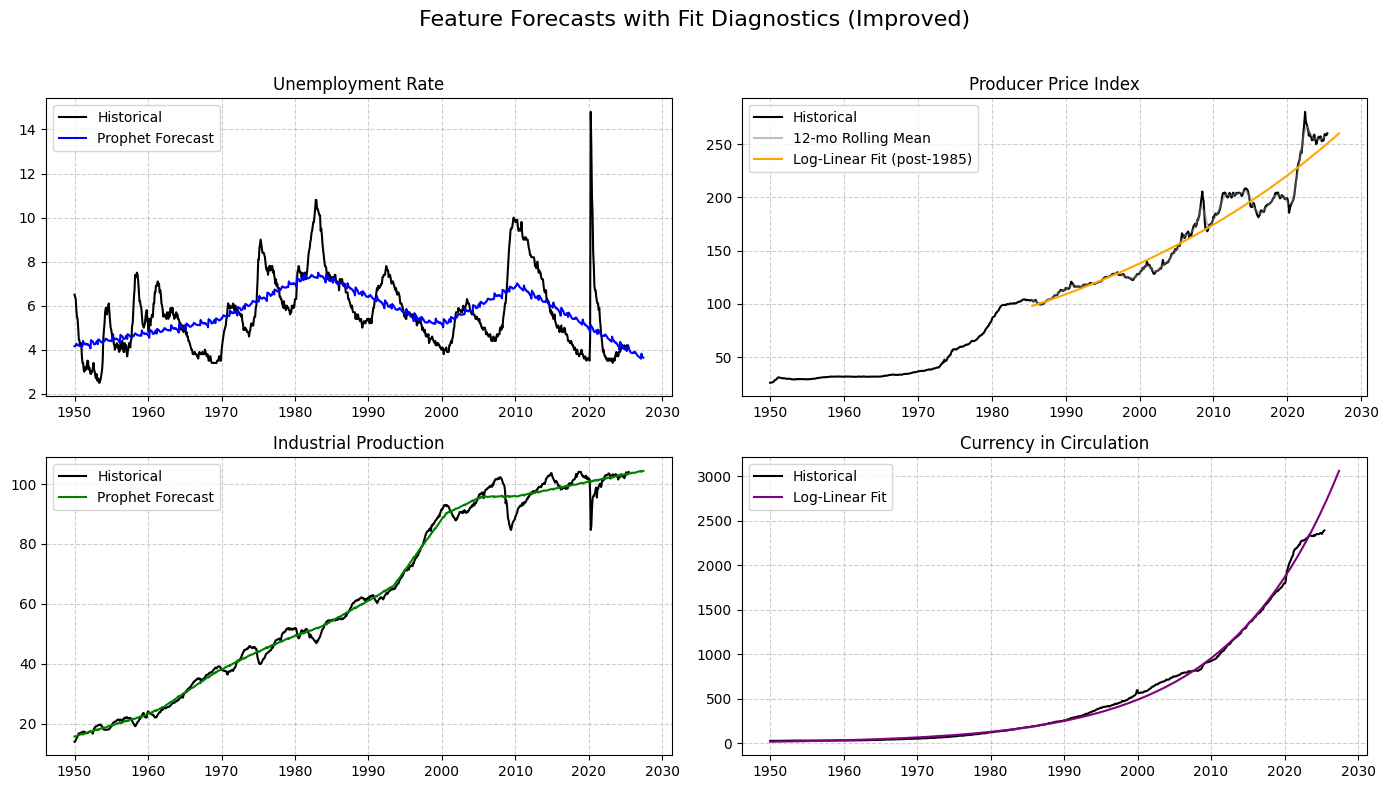

In [ ]:
# Parameters
n_months = 24
last_date = df_raw_features.index.max()
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=n_months, freq='MS')

# 1. Unemployment Rate - Prophet with Yearly Seasonality

# Prepare data
df_unemp = df_raw_features[['unemployment_rate']].dropna().reset_index()
df_unemp.columns = ['ds', 'y']

# Initialize and fit model
model_unemp = Prophet()
model_unemp.add_seasonality(name='yearly', period=365.25, fourier_order=10)
model_unemp.fit(df_unemp)

# Forecast future
future_unemp = model_unemp.make_future_dataframe(periods=n_months, freq='MS')
forecast_unemp = model_unemp.predict(future_unemp)

# Extract predictions
forecast_unemp_full = forecast_unemp.set_index('ds')['yhat']
forecast_unemp_future = forecast_unemp_full.iloc[-n_months:]

# 2. Producer Price Index (PPI) - Improved Log-linear Fit (from 1985+)
ppi = df_raw_features['producer_price_index']
ppi_recent = ppi[ppi.index >= '1985-01-01']
ppi_smooth = ppi_recent.rolling(12, center=True).mean().dropna()

X_ppi = np.arange(len(ppi_smooth)).reshape(-1, 1)
y_ppi = np.log(ppi_smooth.values).reshape(-1, 1)

model_ppi = LinearRegression()
model_ppi.fit(X_ppi, y_ppi)

X_ppi_future = np.arange(len(ppi_smooth), len(ppi_smooth) + n_months).reshape(-1, 1)
y_ppi_future_log = model_ppi.predict(X_ppi_future)
ppi_future = np.exp(y_ppi_future_log).flatten()

ppi_fitted = np.exp(model_ppi.predict(X_ppi)).flatten()
ppi_all = pd.Series(data=np.concatenate([ppi_fitted, ppi_future]),
                    index=pd.date_range(start=ppi_smooth.index[0], periods=len(ppi_fitted) + n_months, freq='MS'))


# 3. Industrial Production - Prophet
# -------------------------------
df_indprod = df_raw_features[['industrial_production']].reset_index()
df_indprod.columns = ['ds', 'y']

model_indprod = Prophet()
model_indprod.fit(df_indprod)

future_indprod = model_indprod.make_future_dataframe(periods=n_months, freq='MS')
forecast_indprod = model_indprod.predict(future_indprod)

forecast_indprod_full = forecast_indprod.set_index('ds')['yhat']
forecast_indprod_future = forecast_indprod_full.iloc[-n_months:]

# 4. Currency Circulation - Log-linear regression
currcirc = df_raw_features['currency_circulation']
X_cc = np.arange(len(currcirc)).reshape(-1, 1)
y_cc = np.log(currcirc.values).reshape(-1, 1)

model_cc = LinearRegression()
model_cc.fit(X_cc, y_cc)

X_cc_future = np.arange(len(currcirc), len(currcirc) + n_months).reshape(-1, 1)
y_cc_future_log = model_cc.predict(X_cc_future)
cc_future = np.exp(y_cc_future_log).flatten()

cc_fitted = np.exp(model_cc.predict(X_cc)).flatten()
cc_all = pd.Series(data=np.concatenate([cc_fitted, cc_future]),
                   index=pd.date_range(start=currcirc.index[0], periods=len(cc_fitted) + n_months, freq='MS'))

# Combine future forecasts
future_features = pd.DataFrame({
    'unemployment_rate': forecast_unemp_future,
    'producer_price_index': ppi_all.iloc[-n_months:].values,
    'industrial_production': forecast_indprod_future,
    'currency_circulation': cc_all.iloc[-n_months:].values
}, index=future_dates)

print("✅ Forecasted features for future months:")
print(future_features.head())

# Visual diagnostics (fit + forecast)
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
axs = axs.flatten()

# Unemployment
# Unemployment Rate Plot
axs[0].plot(df_raw_features.index, df_raw_features['unemployment_rate'], label='Historical', color='black')
axs[0].plot(forecast_unemp_full.index, forecast_unemp_full.values, label='Prophet Forecast', color='blue')
axs[0].set_title("Unemployment Rate")
axs[0].legend()

# PPI
axs[1].plot(ppi.index, ppi.values, label='Historical', color='black')
axs[1].plot(ppi_smooth.index, ppi_smooth.values, label='12-mo Rolling Mean', color='gray', alpha=0.5)
axs[1].plot(ppi_all.index, ppi_all.values, label='Log-Linear Fit (post-1985)', color='orange')
axs[1].set_title("Producer Price Index")
axs[1].legend()

# Industrial Production
axs[2].plot(df_raw_features.index, df_raw_features['industrial_production'], label='Historical', color='black')
axs[2].plot(forecast_indprod_full.index, forecast_indprod_full.values, label='Prophet Forecast', color='green')
axs[2].set_title("Industrial Production")
axs[2].legend()

# Currency Circulation
axs[3].plot(currcirc.index, currcirc.values, label='Historical', color='black')
axs[3].plot(cc_all.index, cc_all.values, label='Log-Linear Fit', color='purple')
axs[3].set_title("Currency in Circulation")
axs[3].legend()

# Final styling
for ax in axs:
    ax.grid(True, linestyle='--', alpha=0.6)

plt.suptitle("Feature Forecasts with Fit Diagnostics (Improved)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

While these models do not perfectly fit, they follow the overarching trends and ignore fluctuations. These give us the imputed values we will need when generating our 2-year forecast!

### Forecasting

In [ ]:
# Full model training setup (no test split)
df_full = df.copy()
target_col = 'inflation'
feature_cols = [col for col in df_full.columns if col != target_col]

X = df_full[feature_cols]
y = df_full[[target_col]]

# Refit scalers on the full data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y)

# Sequence parameters
n_steps = 12

# Create sequences for RNN/LSTM
def create_sequences(X, y, n_steps):
    Xs, ys = [], []
    for i in range(n_steps, len(X)):
        Xs.append(X[i - n_steps:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, n_steps)

# Train models

# LightGBM
lgb_model = lgb.LGBMRegressor()
lgb_model.fit(X_scaled, y_scaled.ravel())

# DNN
dnn_model = Sequential([
    Input(shape=(X_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])
dnn_model.compile(optimizer=Adam(0.001), loss='mae')
dnn_model.fit(X_scaled, y_scaled, epochs=50, batch_size=16, verbose=0,
              callbacks=[EarlyStopping(patience=5)])

# RNN
rnn_model = Sequential([
    SimpleRNN(64, return_sequences=True, input_shape=(n_steps, X_scaled.shape[1])),
    SimpleRNN(32),
    Dense(1)
])
rnn_model.compile(optimizer=Adam(0.001), loss='mae')
rnn_model.fit(X_seq, y_seq, epochs=100, batch_size=16, verbose=0,
              validation_split=0.1, callbacks=[EarlyStopping(patience=10)])

# LSTM
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(n_steps, X_scaled.shape[1])),
    LSTM(32),
    Dense(1)
])
lstm_model.compile(optimizer=Adam(0.001), loss='mae')
lstm_model.fit(X_seq, y_seq, epochs=100, batch_size=16, verbose=0,
               validation_split=0.1, callbacks=[EarlyStopping(patience=10)])

# Use the last sequence to generate pseudo-test predictions to compute ensemble weights
X_test_seq = X_scaled[-(n_steps + 25):]  # use last 25 targets for weight calibration
X_dnn_lgb_test = X_test_seq[n_steps:]   # shape (25, n_features)
X_rnn_lstm_seq, y_last = create_sequences(X_test_seq, y_scaled[-(n_steps + 25):], n_steps)

dnn_pred_seq = dnn_model.predict(X_dnn_lgb_test).flatten()
lgb_pred_seq = lgb_model.predict(X_dnn_lgb_test).flatten()
rnn_pred_seq = rnn_model.predict(X_rnn_lstm_seq).flatten()
lstm_pred_seq = lstm_model.predict(X_rnn_lstm_seq).flatten()

# Compute MAEs and softmax weights (optional placeholder)
# Updated for sequence predictions (25 test points)
maes = np.array([
    mean_absolute_error(y_test_adjusted, dnn_pred_seq),
    mean_absolute_error(y_test_adjusted, rnn_pred_seq),
    mean_absolute_error(y_test_adjusted, lstm_pred_seq),
    mean_absolute_error(y_test_adjusted, lgb_pred_seq)
])
model_preds = [dnn_pred_seq, rnn_pred_seq, lstm_pred_seq, lgb_pred_seq]

# Top-3 model selection
top3_idx = np.argsort(maes)[:3]
top3_maes = maes[top3_idx]
top3_preds = [model_preds[i] for i in top3_idx]

# Softmax with strong weighting for best
beta = 7.5
weights = np.exp(-beta * top3_maes)
weights /= weights.sum()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5494
[LightGBM] [Info] Number of data points in the train set: 906, number of used features: 29
[LightGBM] [Info] Start training from score 0.336514


c:\Users\shreyas.ramulu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)
c:\Users\shreyas.ramulu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


In [ ]:
# Recursive Forecast with imputed lags
forecast_months = 24
forecasted_inflation = []
forecast_index = []
current_df = df_full.copy()
last_known_date = current_df.index.max()
macro_features = list(future_features.columns)
all_lags = [1, 3, 6, 12, 24]
forecast_scale_cols = feature_cols.copy()

# Start with the last n_steps sequences from training
rnn_lstm_seq_buffer = list(X_scaled[-n_steps:])

for i in range(forecast_months):
    next_date = last_known_date + pd.DateOffset(months=1)
    row = {}

    # Use imputed values
    if next_date in future_features.index:
        for col in macro_features:
            row[col] = future_features.loc[next_date, col]

    # Add macro + inflation lags
    for lag in all_lags:
        lag_date = next_date - pd.DateOffset(months=lag)
        if lag_date in current_df.index:
            row[f'inflation_lag_{lag}'] = current_df.loc[lag_date, 'inflation']
        elif lag_date in forecast_index:
            idx = forecast_index.index(lag_date)
            row[f'inflation_lag_{lag}'] = forecasted_inflation[idx]
        else:
            row[f'inflation_lag_{lag}'] = np.nan

        for macro_col in macro_features:
            if lag_date in df_full.index:
                row[f'{macro_col}_lag_{lag}'] = df_full.loc[lag_date, f'{macro_col}_lag_{lag}']
            elif lag_date in future_features.index:
                row[f'{macro_col}_lag_{lag}'] = future_features.loc[lag_date, macro_col]
            else:
                row[f'{macro_col}_lag_{lag}'] = np.nan

    # Calendar
    row['month_sin'] = np.sin(2 * np.pi * next_date.month / 12)
    row['month_cos'] = np.cos(2 * np.pi * next_date.month / 12)
    row['quarter_sin'] = np.sin(2 * np.pi * ((next_date.month - 1) // 3 + 1) / 4)
    row['quarter_cos'] = np.cos(2 * np.pi * ((next_date.month - 1) // 3 + 1) / 4)

    row_df = pd.DataFrame(row, index=[next_date])

    # Drop raw cols and fill missing
    row_df = row_df.drop(columns=[col for col in macro_features if col in row_df.columns])
    for col in forecast_scale_cols:
        if col not in row_df.columns:
            row_df[col] = np.nan
    row_df.fillna(method='ffill', inplace=True)
    row_df.fillna(method='bfill', inplace=True)

    # Scale
    row_df_scaled = row_df.copy()
    row_df_scaled[forecast_scale_cols] = scaler.transform(row_df_scaled[forecast_scale_cols])

    # Predict
    dnn_p = dnn_model.predict(row_df_scaled).flatten()[0]
    
    # Update sequence buffer
    rnn_lstm_seq_buffer.append(row_df_scaled.values[0])  # append current row
    rnn_lstm_seq_buffer = rnn_lstm_seq_buffer[-n_steps:]  # keep last n_steps

    # Reshape to (1, n_steps, num_features)
    sequence_input = np.array(rnn_lstm_seq_buffer).reshape((1, n_steps, row_df_scaled.shape[1]))

    # Predict
    rnn_p = rnn_model.predict(sequence_input).flatten()[0]
    lstm_p = lstm_model.predict(sequence_input).flatten()[0]

    lgb_p = lgb_model.predict(row_df_scaled).flatten()[0]

 
    # Define MAE dictionary after model evaluation
    mae_dict = {
        'dnn': dnn_mae,
        'rnn': rnn_mae,
        'lstm': lstm_mae,
        'lgb': lgb_mae
    }

    # Sort models by MAE
    sorted_items = sorted(mae_dict.items(), key=lambda x: x[1])
    top3_models, top3_maes = zip(*sorted_items[:3])  # Tuple of names and MAEs

    # Compute softmax weights for top 3
    beta = 7.5
    weights = np.exp(-beta * np.array(top3_maes))
    weights /= weights.sum()

    pred_map = {
    'dnn': dnn_p,
    'rnn': rnn_p,
    'lstm': lstm_p,
    'lgb': lgb_p
    }

    # Step 3: Compute ensemble prediction from top 3 models
    pred_scaled = sum(pred_map[model] * weight for model, weight in zip(top3_models, weights))

    # Step 4: Inverse transform
    pred_unscaled = y_scaler.inverse_transform([[pred_scaled]])[0, 0]
    forecasted_inflation.append(pred_unscaled)
    forecast_index.append(next_date)

    # For future lag use
    row_df['inflation'] = pred_unscaled
    current_df = pd.concat([current_df, row_df[['inflation']]])
    last_known_date = next_date

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='ffill', inplace=True)
C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='bfill', inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='ffill', inplace=True)
C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='bfill', inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='ffill', inplace=True)
C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='bfill', inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='ffill', inplace=True)
C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='bfill', inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='ffill', inplace=True)
C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='bfill', inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='ffill', inplace=True)
C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='bfill', inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='ffill', inplace=True)
C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='bfill', inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='ffill', inplace=True)
C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='bfill', inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='ffill', inplace=True)
C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='bfill', inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='ffill', inplace=True)
C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='bfill', inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='ffill', inplace=True)
C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='bfill', inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='ffill', inplace=True)
C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='bfill', inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='ffill', inplace=True)
C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='bfill', inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='ffill', inplace=True)
C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='bfill', inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='ffill', inplace=True)
C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='bfill', inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='ffill', inplace=True)
C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='bfill', inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='ffill', inplace=True)
C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='bfill', inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='ffill', inplace=True)
C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='bfill', inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='ffill', inplace=True)
C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='bfill', inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='ffill', inplace=True)
C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='bfill', inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='ffill', inplace=True)
C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='bfill', inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='ffill', inplace=True)
C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='bfill', inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='ffill', inplace=True)
C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='bfill', inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='ffill', inplace=True)
C:\Users\shreyas.ramulu\AppData\Local\Temp\ipykernel_26072\4147503547.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  row_df.fillna(method='bfill', inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


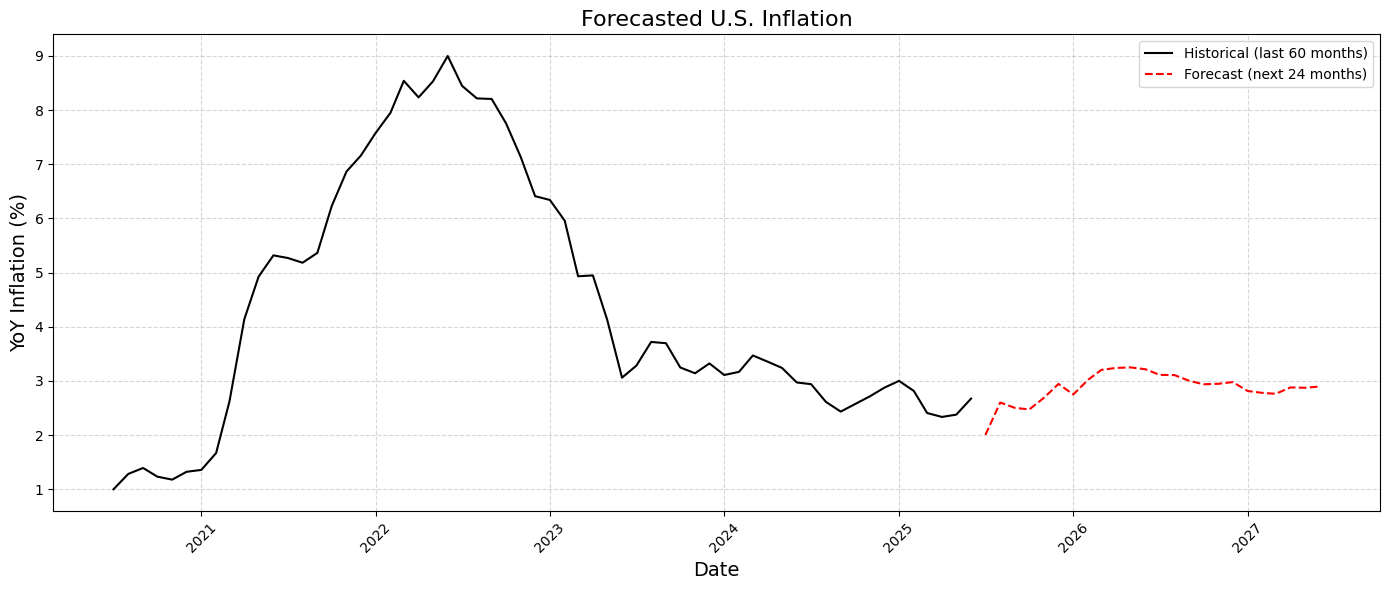

In [ ]:
# Plot
forecast_series = pd.Series(forecasted_inflation, index=forecast_index)

# Historical inflation tail
historical_tail = df['inflation'].iloc[-60:]  # last 60 months

plt.figure(figsize=(14, 6))
plt.plot(historical_tail.index, historical_tail.values, label='Historical (last 60 months)', color='black')
plt.plot(forecast_series.index, forecast_series.values, color='red', linestyle='--', label='Forecast (next 24 months)')
plt.title('Forecasted U.S. Inflation', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('YoY Inflation (%)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()